# Mutual Information


## 1. Conjunto de Dados

### 1.1. Gera dados correlacionados de formas não lineares

In [1]:
import random
import pandas as pd
import numpy as np

tamanho = 1000
x = np.random.normal(0, 10, size=tamanho)
dados_randomicos = pd.DataFrame({'x': x, 'y': np.random.normal(-4, 1, size=tamanho)})
dados_linear = pd.DataFrame({'x': x, 'y': 2*x + np.random.normal(0, 1, size=tamanho)})
dados_quadraticos = pd.DataFrame({'x': x, 'y': x**2 + np.random.normal(4, 0.25, size=tamanho)})
dados_exponencial = pd.DataFrame({'x': x, 'y': np.exp(x/10) + np.random.normal(5, 0.5, size=tamanho)})
dados_senoidal = pd.DataFrame({'x': x, 'y': np.sin(x) + np.random.normal(2, 0.1, size=tamanho)})
dados_circular = pd.DataFrame({'x': np.cos(x) + np.random.normal(2, 0.1, size=tamanho), 'y': np.sin(x) + np.random.normal(4, 0.1, size=tamanho)})


#### Gráfico dos dados Gerados

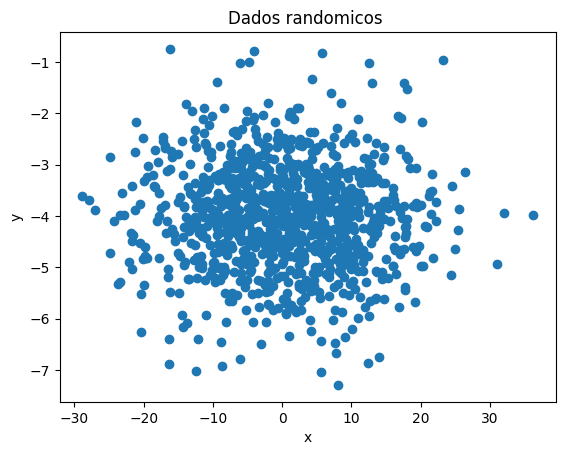

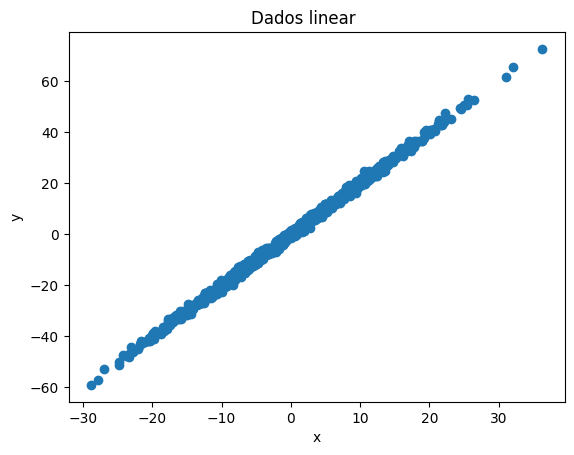

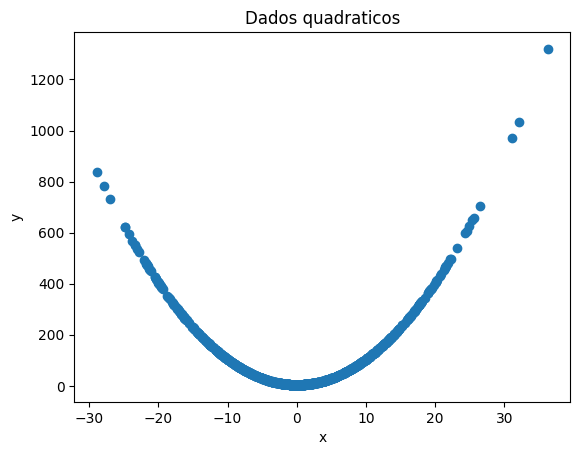

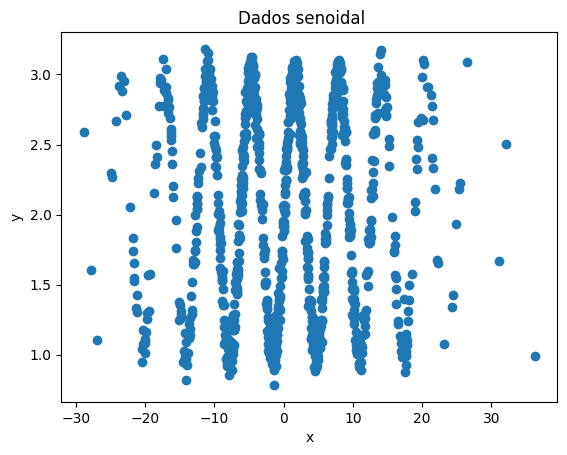

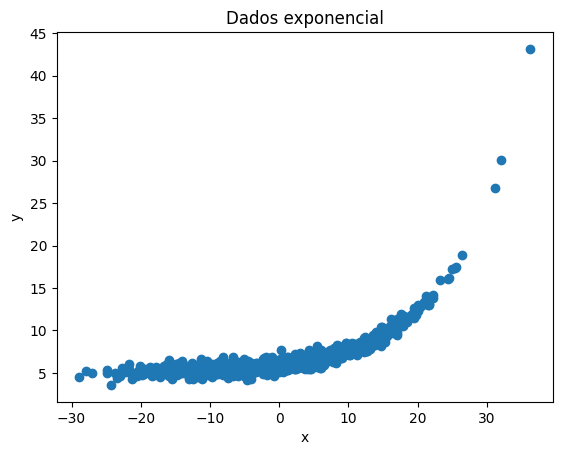

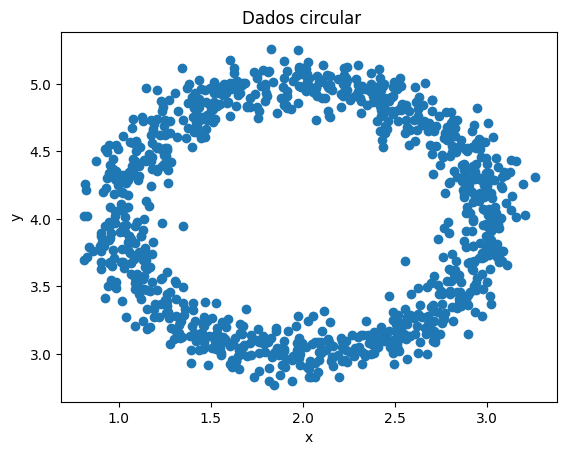

In [2]:

import matplotlib.pyplot as plt

dados_list = [dados_randomicos, dados_linear, dados_quadraticos, dados_senoidal, dados_exponencial, dados_circular]
dados_str = ['randomicos ', 'linear     ', 'quadraticos', 'senoidal   ', 'exponencial', 'circular   ']

for idx, dados in enumerate(dados_list):
    plt.plot(dados['x'], dados['y'], 'o')
    plt.title(f'Dados {dados_str[idx]}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

### Gera dados novos

In [4]:
import random
import pandas as pd
import numpy as np

tamanho = 1000
x_b = np.random.normal(50, 10, size=tamanho)
x_lin = np.random.normal(60, 12, size=tamanho)
x_quad = np.random.normal(20, 20, size=tamanho)
x_exp = np.random.normal(10, 1, size=tamanho)
x_sin = np.random.normal(100, 10, size=tamanho)
y = x_b + 15*x_lin + 5*x_quad**2 + 10*np.exp(x_exp/10) + 20*np.sin(2*np.pi*x_sin) + np.random.normal(0, 1, size=tamanho)
dado = pd.DataFrame({'x_b': x_b, 'x_lin': x_lin, 'x_quad': x_quad, 'x_exp': x_exp, 'x_sin': x_sin, 'y': y})

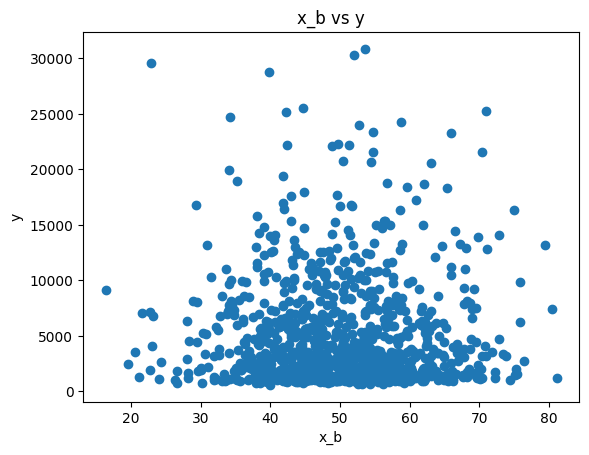

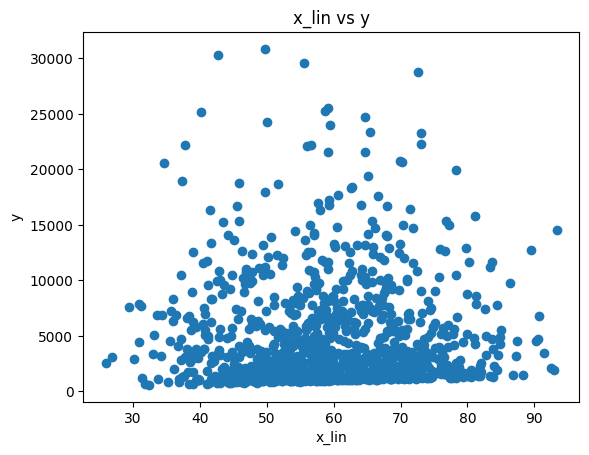

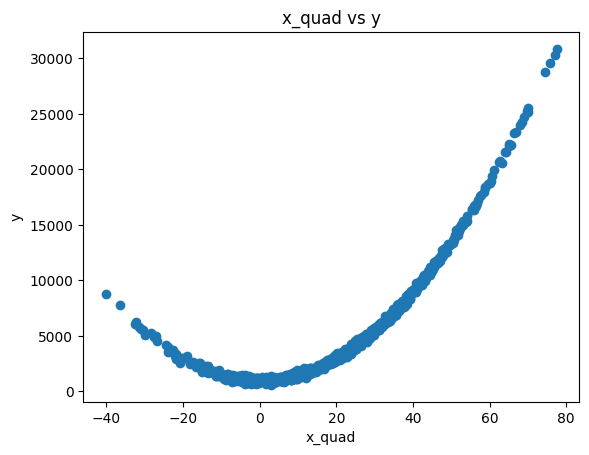

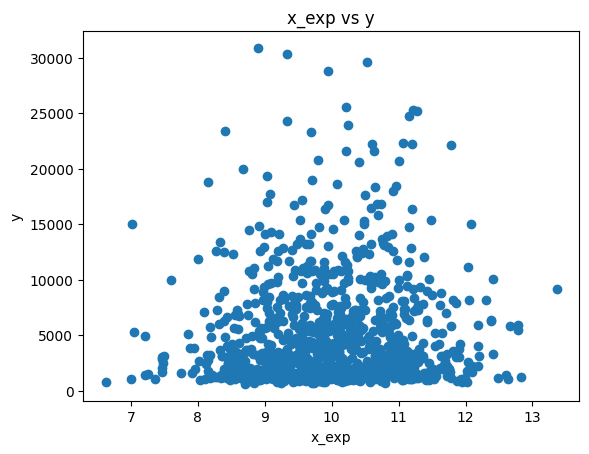

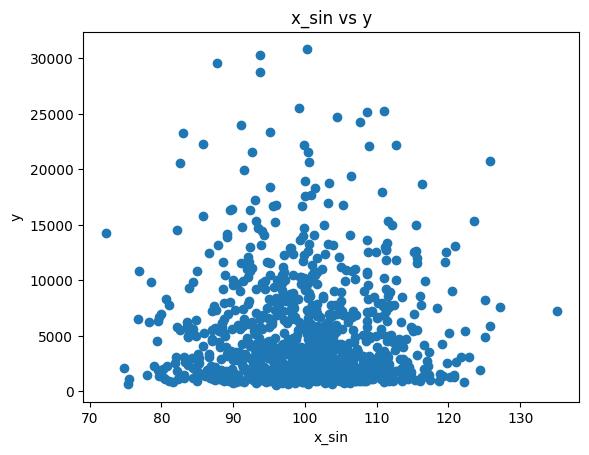

In [5]:
import matplotlib.pyplot as plt
colunas = dado.columns[:-1]

for idx, col in enumerate(colunas):
    plt.plot(dado[col], dado['y'], 'o')
    plt.title(f'{col} vs y')
    plt.xlabel(col)
    plt.ylabel('y')
    plt.show()

### 1.2. Importa dados da PETR4

In [6]:
dados_petr = pd.read_csv("Caracteristicas_Tudo_PETR4_25894_FROM_2018_09_28_TO_2025_04_01.csv")
dados_petr

,Unnamed: 0,time,real_volume,tamanho_corpo,tamanho,tamanho_max,tamanho_min,gap
0,0,2018-10-01,56189700,-0.09,0.21,0.095,0.115,0.05
1,1,2018-10-02,126848000,0.30,0.34,0.150,0.190,0.37
2,2,2018-10-03,151327500,-0.54,0.72,0.330,0.390,0.90
3,3,2018-10-04,98887200,0.21,0.48,0.295,0.185,-0.13
4,4,2018-10-05,104276400,-0.20,0.34,0.130,0.210,0.18
...,...,...,...,...,...,...,...,...
1609,1609,2025-03-26,26846300,0.24,0.48,0.360,0.120,0.11
1610,1610,2025-03-27,28378300,0.24,0.58,0.420,0.160,0.04
1611,1611,2025-03-28,22028300,-0.22,0.79,0.340,0.450,-0.02
1612,1612,2025-03-31,25991000,-0.19,0.56,0.385,0.175,-0.08


Cria o atributo prever

In [7]:
dados_petr['prever'] = dados_petr['tamanho_corpo'].shift(-1)
dados_petr = dados_petr.dropna()
dados_petr = dados_petr.reset_index(drop=True)
dados_petr

,Unnamed: 0,time,real_volume,tamanho_corpo,tamanho,tamanho_max,tamanho_min,gap,prever
0,0,2018-10-01,56189700,-0.09,0.21,0.095,0.115,0.05,0.30
1,1,2018-10-02,126848000,0.30,0.34,0.150,0.190,0.37,-0.54
2,2,2018-10-03,151327500,-0.54,0.72,0.330,0.390,0.90,0.21
3,3,2018-10-04,98887200,0.21,0.48,0.295,0.185,-0.13,-0.20
4,4,2018-10-05,104276400,-0.20,0.34,0.130,0.210,0.18,-0.13
...,...,...,...,...,...,...,...,...,...
1608,1608,2025-03-25,27976600,0.19,0.89,0.575,0.315,0.10,0.24
1609,1609,2025-03-26,26846300,0.24,0.48,0.360,0.120,0.11,0.24
1610,1610,2025-03-27,28378300,0.24,0.58,0.420,0.160,0.04,-0.22
1611,1611,2025-03-28,22028300,-0.22,0.79,0.340,0.450,-0.02,-0.19


#### Gráficos dos dados em relação ao Prever

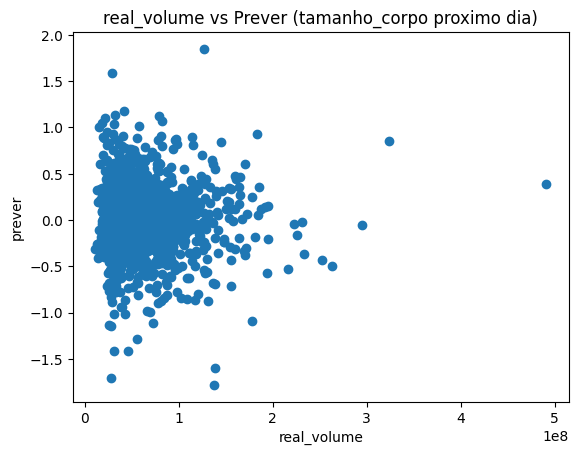

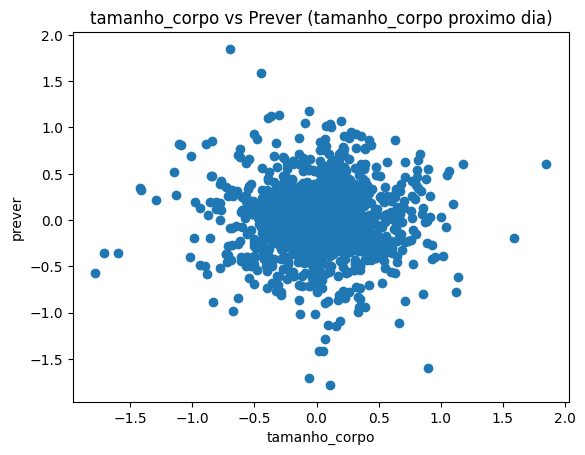

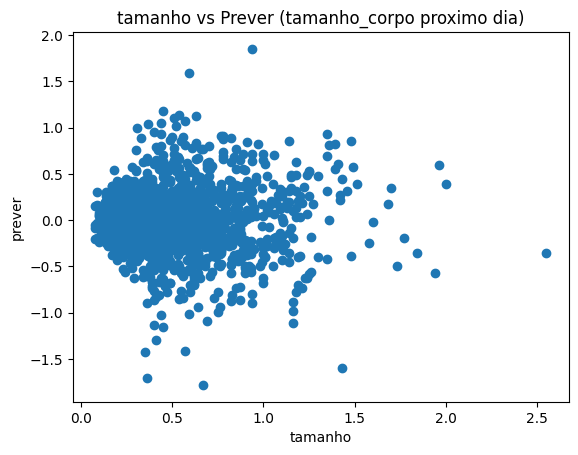

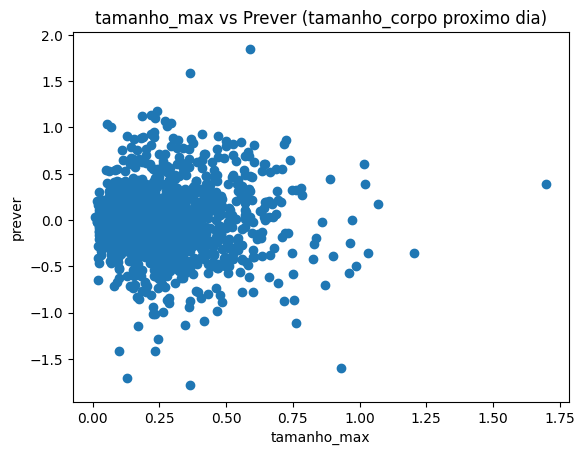

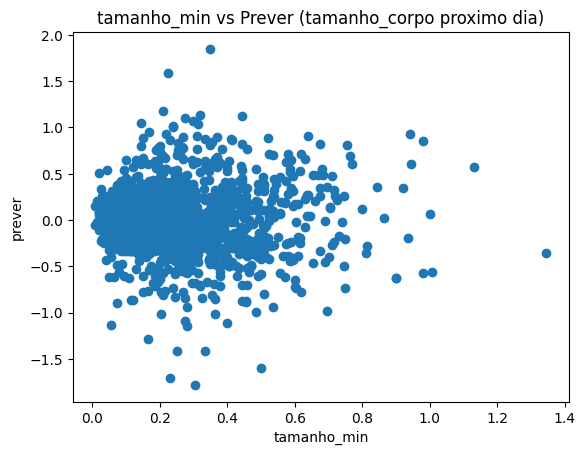

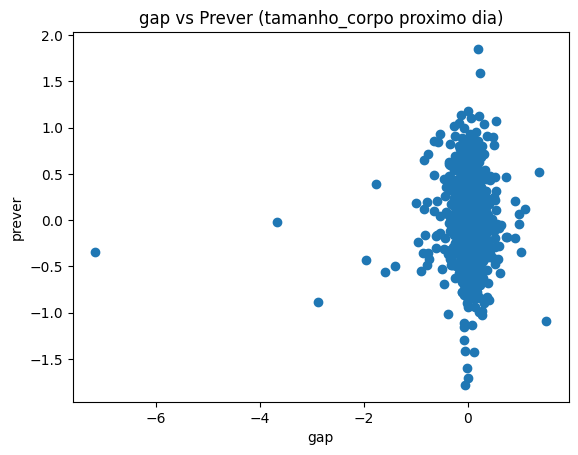

In [5]:
colunas = dados_petr.columns[2:-1]

for idx, col in enumerate(colunas):
    plt.plot(dados_petr[col], dados_petr['prever'], 'o')
    plt.title(f'{col} vs Prever (tamanho_corpo proximo dia)')
    plt.xlabel(col)
    plt.ylabel('prever')
    plt.show()

## 2. Cálculo da *Mutual Information*

Calculo da *Mutual Information* por meio do hitograma. A forma de definir o número de bins pode ser escolhido entre os métodos Classico, Struges, Scoot e Freedman-Diaconis.

In [8]:
def calc_mi(x, y, bins_rule='classic'):
    '''Calcula a Mutual Information entre duas variáveis x e y usando histogramas.
    Parâmetros:
    x: array-like, primeira variável.
    y: array-like, segunda variável.
    bins_rule: str, regra para determinar o número de bins. Opções: 'classic', 'sturges', 'scott', 'fd'.
    Retorna:
    mi: float, valor da Mutual Information.
    '''

    if bins_rule == 'classic':
        bins_x = int(len(x)**0.5)
        bins_y = int(len(y)**0.5)
    elif bins_rule == 'sturges':
        bins_x = int(np.ceil(np.log2(len(x)) + 1))
        bins_y = int(np.ceil(np.log2(len(y)) + 1))
    elif bins_rule == 'scott': #ótima para distribuição normal
        bins_x = int((np.max(x) - np.min(x)) / (3.5 * np.std(x) * len(x)**(-1/3)))
        bins_y = int((np.max(y) - np.min(y)) / (3.5 * np.std(y) * len(y)**(-1/3)))
    elif bins_rule == 'fd': #mais robusta para outliers
        bins_x = int((np.max(x) - np.min(x)) / (2 * (np.percentile(x, 75) - np.percentile(x, 25)) * len(x)**(-1/3)))
        bins_y = int((np.max(y) - np.min(y)) / (2 * (np.percentile(y, 75) - np.percentile(y, 25)) * len(y)**(-1/3)))
    

    hist2d, x_edges, y_edges = np.histogram2d(x, y, bins=[bins_x, bins_y])

    hist2d_norm = hist2d / np.sum(hist2d)

    hist_x = np.sum(hist2d_norm, axis=1)
    hist_y = np.sum(hist2d_norm, axis=0)

    entropia_x = -sum(hist_x[hist_x > 0] * np.log(hist_x[hist_x > 0]))
    entropia_y = -sum(hist_y[hist_y > 0] * np.log(hist_y[hist_y > 0]))

    entropia_conjunta = -sum(hist2d_norm[hist2d_norm > 0] * np.log(hist2d_norm[hist2d_norm > 0]))

    mi = entropia_x + entropia_y - entropia_conjunta

    return mi

**Dúvida:** Na minha cabeça faz mais sentido colocar os os métodos de determinação da bin como entrada, pode ser assim?

### 2.1. Teste da função

In [9]:
dados_list = [dados_randomicos, dados_linear, dados_quadraticos, dados_senoidal, dados_exponencial, dados_circular]
dados_str = ['randomicos ', 'linear     ', 'quadraticos', 'senoidal   ', 'exponencial', 'circular   ']
bins_rule = ['classic', 'sturges', 'scott', 'fd']


print(f'    Dado     | {bins_rule[0]} | {bins_rule[1]} |  {bins_rule[2]}  |  {bins_rule[3]}')
print('-------------|---------|---------|---------|--------')
for idx, dados in enumerate(dados_list):
    bins_list = []
    for br in bins_rule:
        bins_list.append(calc_mi(dados['x'], dados['y'], bins_rule=br))
    print(f'{dados_str[idx]}  |  {bins_list[0]:.3f}  |  {bins_list[1]:.3f}  |  {bins_list[2]:.3f}  |  {bins_list[3]:.3f}')
    

    Dado     | classic | sturges |  scott  |  fd
-------------|---------|---------|---------|--------
randomicos   |  0.329  |  0.035  |  0.107  |  0.203
linear       |  2.339  |  1.680  |  2.008  |  2.185
quadraticos  |  1.500  |  0.700  |  1.280  |  1.580
senoidal     |  0.829  |  0.068  |  0.286  |  0.421
exponencial  |  0.849  |  0.516  |  0.913  |  1.025
circular     |  0.902  |  0.572  |  0.540  |  0.541


### 2.2. Testes com dados da PETR4

In [10]:
colunas = dados_petr.columns[2:-1]

print(f'    Dado     | {bins_rule[0]} | {bins_rule[1]} |  {bins_rule[2]}  |  {bins_rule[3]}')
print('-------------|---------|---------|---------|--------')
for idx, col in enumerate(colunas):
    bins_list = []
    for br in bins_rule:
        bins_list.append(calc_mi(dados_petr[col], dados_petr['prever'], bins_rule=br))
    print(f'{col.ljust(13)}|  {bins_list[0]:.3f}  |  {bins_list[1]:.3f}  |  {bins_list[2]:.3f}  |  {bins_list[3]:.3f}')
    

    Dado     | classic | sturges |  scott  |  fd
-------------|---------|---------|---------|--------
real_volume  |  0.152  |  0.024  |  0.145  |  0.291
tamanho_corpo|  0.230  |  0.051  |  0.186  |  0.384
tamanho      |  0.264  |  0.101  |  0.201  |  0.335
tamanho_max  |  0.217  |  0.067  |  0.175  |  0.308
tamanho_min  |  0.256  |  0.076  |  0.194  |  0.339
gap          |  0.093  |  0.020  |  0.148  |  0.392


### 2.3 Teste dados

In [11]:
colunas = dado.columns[:-1]

print(f'    Dado     | {bins_rule[0]} | {bins_rule[1]} |  {bins_rule[2]}  |  {bins_rule[3]}')
print('-------------|---------|---------|---------|--------')
for idx, col in enumerate(colunas):
    bins_list = []
    for br in bins_rule:
        bins_list.append(calc_mi(dado[col], dado['y'], bins_rule=br))
    print(f'{col.ljust(13)}|  {bins_list[0]:.3f}  |  {bins_list[1]:.3f}  |  {bins_list[2]:.3f}  |  {bins_list[3]:.3f}')
    

    Dado     | classic | sturges |  scott  |  fd
-------------|---------|---------|---------|--------
x_b          |  0.266  |  0.036  |  0.101  |  0.194
x_lin        |  0.290  |  0.045  |  0.094  |  0.184
x_quad       |  1.947  |  1.051  |  1.432  |  1.750
x_exp        |  0.272  |  0.046  |  0.098  |  0.203
x_sin        |  0.257  |  0.040  |  0.113  |  0.198


## 3. Hilbert-Schmidt Independence Criterion (HSIC)

In [12]:
from sklearn.metrics.pairwise import rbf_kernel

def calc_hsic(x, y, sigma_x = None, sigma_y = None):

    x = np.asarray(x)
    y = np.asarray(y)

    len_x = len(x)

    H = np.eye(len_x) - np.ones((len_x, len_x))/len_x

    if sigma_x is None:
        sigma_x = np.median(np.abs(x[:, None] - x[None, :]))

    if sigma_y is None:
        sigma_y = np.median(np.abs(y[:, None] - y[None, :]))

    K = rbf_kernel(x.reshape(-1, 1), gamma=1/(2*sigma_x**2))
    L = rbf_kernel(y.reshape(-1, 1), gamma=1/(2*sigma_y**2))

    return np.trace(H @ K @ H @ L) / (len_x - 1)**2    

### 3.1 Teste dados Gerados

In [14]:
print(f'    Dado     | HSIC ')
print('-------------|---------')
for idx, dados in enumerate(dados_list):
    hsic = calc_hsic(dados['x'], dados['y'])
    print(f'{dados_str[idx]}  |  {hsic:.3f} ')

    Dado     | HSIC 
-------------|---------
randomicos   |  0.000 
linear       |  0.078 
quadraticos  |  0.030 
senoidal     |  0.000 
exponencial  |  0.048 
circular     |  0.007 


### 3.2 Teste PETR4

In [17]:
colunas = dados_petr.columns[2:-1]

print(f'    Dado     | HSIC')
print('-------------|---------')
for idx, col in enumerate(colunas):
    hsic = calc_hsic(dados_petr[col], dados_petr['prever'])
    print(f'{col.ljust(13)}|  {hsic:.3f}')

    Dado     | HSIC
-------------|---------
real_volume  |  0.000
tamanho_corpo|  0.001
tamanho      |  0.005
tamanho_max  |  0.004
tamanho_min  |  0.004
gap          |  0.001


### 3.3 Teste dados Gerados 1

In [19]:
colunas = dado.columns[:-1]

print(f'    Dado     | HSIC')
print('-------------|---------')
for idx, col in enumerate(colunas):
    hsic = calc_hsic(dado[col], dado['y'])
    print(f'{col.ljust(13)}|  {hsic:.4f}')

    Dado     | HSIC
-------------|---------
x_b          |  0.0001
x_lin        |  0.0001
x_quad       |  0.0627
x_exp        |  0.0003
x_sin        |  0.0001


**Dúvida:** Na minha cabeça faz mais sentido calcular o sigma para os dados inseridos, pode ser assim?

## 4. Modelo

Definir os dados a serem usados e separar em treino, validação e teste

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Usar dados gerados

In [31]:
dados_usado = dados_exponencial

X_train_val, X_test, y_train_val, y_test = train_test_split(dados_usado['x'], dados_usado['y'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

Usar dados da PETR4

In [44]:
X_train_val, X_test, y_train_val, y_test = train_test_split(dados_petr[dados_petr.columns[2:-1]], dados_petr['prever'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

Usar dados Gerados 1

In [22]:
X_train_val, X_test, y_train_val, y_test = train_test_split(dado[dado.columns[:-1]], dado['y'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [23]:
print(X_train.shape, y_train.shape)

(640, 5) (640,)


### 4.1 xgBoost

In [39]:
from xgboost import XGBRegressor
import xgboost

In [45]:
model = XGBRegressor()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)
print(f'MSE Treino: {mse_train:.4f}')

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE Teste: {mse:.4f}')

MSE Treino: 0.0015
MSE Teste: 0.1752


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

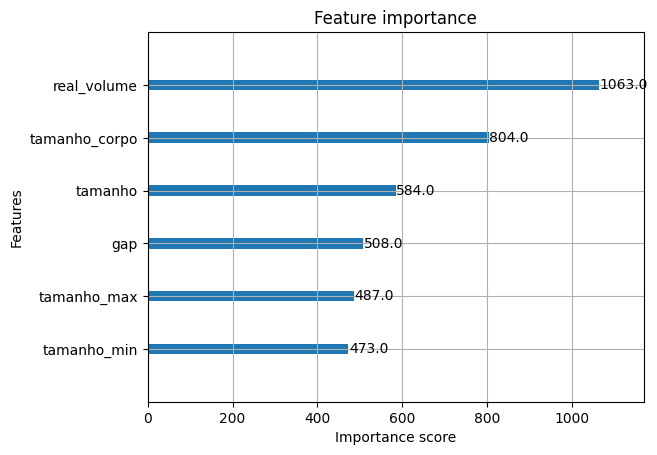

In [46]:
xgboost.plot_importance(model)

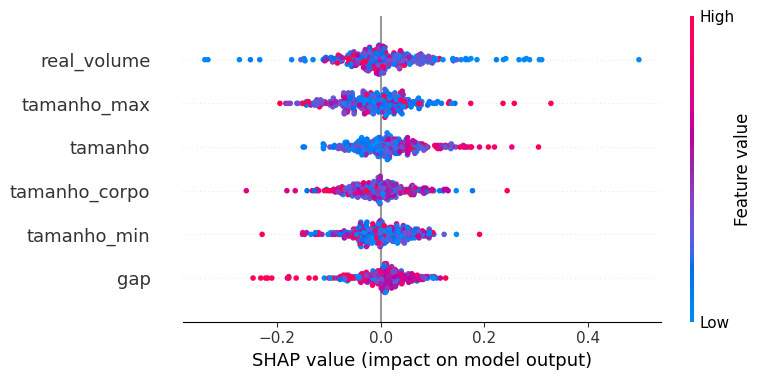

In [47]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

### 4.2 LightGBM

In [48]:
import lightgbm as lgb

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

In [49]:
params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1
}
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[val_data])
y_pred_train_val = bst.predict(X_train_val, num_iteration=bst.best_iteration)
mse_train_val = mean_squared_error(y_train_val, y_pred_train_val)
print(f'LightGBM Train+Val MSE: {mse_train_val:.3f}')

y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
mse = mean_squared_error(y_test, y_pred)
print(f'LightGBM Teste MSE: {mse:.3f}')



LightGBM Train+Val MSE: 0.049
LightGBM Teste MSE: 0.151


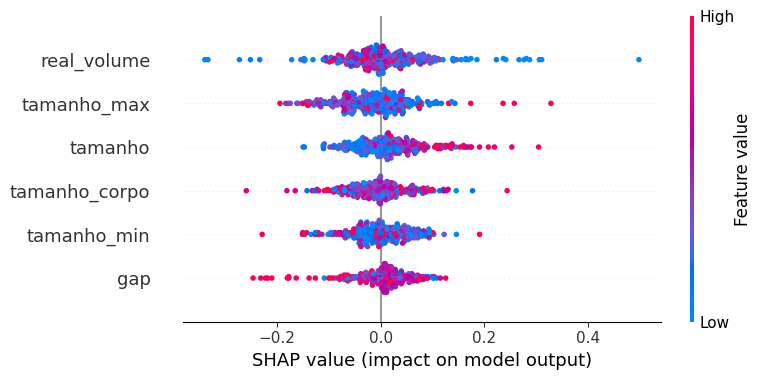

In [50]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)